# Speech Feature Extraction

In this notebook, I explore fundamental techniques for extracting features from speech audio. The focus is on practical implementation using Python and popular libraries.

The goal is to understand how to load audio waveforms, convert them into tensors, and compute key features like spectrograms, mel-spectrograms, and MFCCs. This forms the basis for further work in speech recognition and synthesis.

## Imports

Install the `torchaudio` library, which extends PyTorch with audio processing tools. This makes it straightforward to load audio files as torch tensors, enabling efficient computation and seamless integration with neural network workflows.

In [ ]:
!pip install torchaudio

Adding more libraries that will be used for math and tensor operations (**numpy**, **torch**), as well as **torchaudio** and some plotting utilities (**librosa.display**, **matplotlib**, **IPython**).

In [ ]:
#imports
import numpy as np
import torch
import torchaudio
import librosa.display
import matplotlib.pyplot as plt
import IPython

##  Dataset

For this project, I am using a subset of the Google Speech Commands dataset. This dataset provides short audio clips of spoken words such as "stop", "go", "yes", "no", and others. The data is downloaded automaticaly using `torchaudio`, making it easy to work with real speech samples for feature extraction experiments.

In [ ]:
#Use Torchaudios built in function to directly download this data.
#Documentation: https://pytorch.org/audio/stable/generated/torchaudio.datasets.SPEECHCOMMANDS.html#torchaudio.datasets.SPEECHCOMMANDS
dataset = torchaudio.datasets.SPEECHCOMMANDS(
    root='./',
    url='speech_commands_v0.01',
    download=True,
    subset='testing',
)

100%|██████████| 1.39G/1.39G [00:14<00:00, 101MB/s]


In [ ]:
#get one sample from the dataset
#This will return a tuple with the audio tensor and the label
#The audio tensor is of shape (1, num_samples) and the label is a string
sample_id = 1001
sample = dataset.__getitem__(sample_id)

In [ ]:
# Display the audio tensor and label
sample

(tensor([[-0.0009, -0.0010, -0.0010,  ...,  0.0002, -0.0003, -0.0013]]),
 16000,
 'eight',
 '563aa4e6',
 2)

Documentation can be accesed [here](https://pytorch.org/audio/stable/generated/torchaudio.datasets.SPEECHCOMMANDS.html#torchaudio.datasets.SPEECHCOMMANDS).

The tensor consists of:
- a tensor containing the audio waveform
- the sampling rate
- the label, what is being said in the audio
- the identity of the speaker
- the identifier of the utterance

## Audio visualization

In [ ]:
#split the sample into its components
audio, sampling_rate, label, speaker_id, utterance_id = sample

Shape of the audio tensor = torch.Size([1, 16000])
You see it has two dimensions: The first = 1 and the second = 16000
The first corresponds to the number of channels, in this case 1, because it is a mono audio. It would be 2, if it was stereo, as the songs you listen daily!
The second is the temporal length, meaning that our audio is represented by 16000 numbers. Because our sampling rate is 16000 Hz, it means that 16000 / 16000 = 1 second
___________________________

Let's visualize and listen to the audio! You can see that the audio lasts 1 second indeed.
Also, pay attention to what is being said, it should correspond to the label = eight


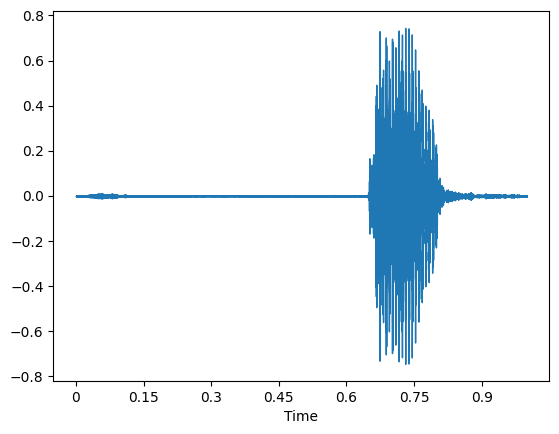

In [ ]:
#Visualize some characteristics of the audio tensor
audio_shape = audio.shape
print(f"Shape of the audio tensor = {audio_shape}")
print(f"Number of channels and temporal length: The first = {audio_shape[0]} and the second = {audio_shape[1]}")
print(f"Label = {label}")

librosa.display.waveshow(audio.numpy(), sr=sampling_rate)
IPython.display.Audio(audio, rate=sampling_rate)

To better understand the concept of sampling rate, I experimented with different values. The sampling rate (in Hz) indicates how many samples are used to represent one second of audio.

For example, the current audio sample uses a rate of 16,000 Hz, so I specify this value when visuallizing or playing the audio. If I instead set the sampling rate to 8,000 Hz for the same waveform (which still has 16,000 samples), the playback duration doubles to 2 seconds. As a result, the audio sounds much slower than intended, since the library interprets the data as a longer recording.

This demonstrates why it is important to always use the correct sampling rate when processing or playing audio data.

In [ ]:
IPython.display.Audio(audio, rate=8000)

In [ ]:
#Using a higher input sampling rate, like 32000 Hz, the audio will sound sped up.
IPython.display.Audio(audio, rate=32000)

## Speech features extraction

Extract some of the most common features used in speech processing. These are:

- **Waveform:** This is the raw audio signal. It contains the most information, but is also the most data-intensive to process. For example, a one-second recording at 16,000 Hz has 16,000 samples, just to represent a simple word like "bed".
- **Spectrogram (STFT):** By applying the Short-Time Fourrier Transform, I convert the 1D waveform into a 2D representation (frequency vs. time). This makes frequency information explicit and is more compact than the raw waveform.
- **Mel-Spectrogram:** This is a spectrogram where the frequency axis is scaled to the mel scale, which better matches human hearing. It reduces the dimensionality and emphasizes perceptually important frequencies.
- **MFCC (Mel Frequency Cepstral Coefficients):** These are computed from the mel-spectrogram and provide a very compact representation, commonly used in speech recognition. Some information is lost, but the features are efficient for machine learning models.

### The waveform

We already inspected the waveform before. Thanks to **torchaudio**, we downloaded a waveform in a tensor format.

In [ ]:
!ls

sample_data  SpeechCommands  speech_commands_v0.01.tar.gz


In [ ]:
waveform_local_path = "./waveform_0.wav"  #: the local path where we save the audio
audio_to_save = audio #: the tensor to be saved as a wav filee
output_sampling_rate = sampling_rate #: the sampling rate at which we save the audio
torchaudio.save(uri=waveform_local_path, src=audio_to_save, sample_rate=output_sampling_rate)
!ls

sample_data  SpeechCommands  speech_commands_v0.01.tar.gz  waveform_0.wav


After saving the audio file locally, I wanted to check if I could load it back from disk into a torch tensor. This is useful for situations where audio data is stored offline and needs to be processed later.  
To do this, I used `torchaudio.load`, which reads the file and returns both the waveform tensor and its sampling rate.

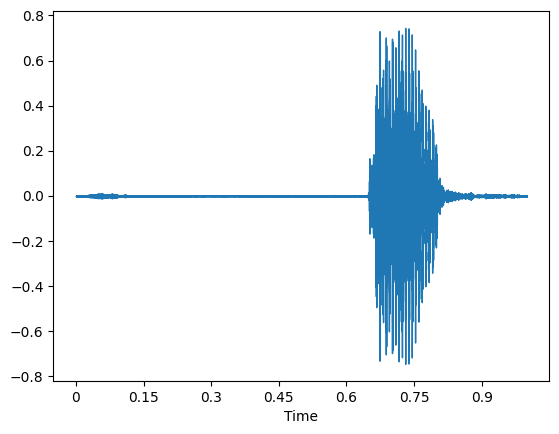

In [ ]:
def load_audio(path):
  #Implement audio waveform loading with Torchaudio here.
  waveform, waveform_sampling_rate = torchaudio.load(uri=path)
  return waveform, waveform_sampling_rate

waveform, waveform_sampling_rate = load_audio(waveform_local_path)

#asserts to check everything is as expected
assert torch.is_tensor(waveform), f"Error! waveform is not a torch tensor, is: {type(waveform)}."
assert waveform.shape == (1, 16000), f"Error! The waveform shape detected is: {waveform.shape}"
assert waveform_sampling_rate == 16000, f"Error! The waveform sampling rate is not the expected one: {waveform_sampling_rate}"

librosa.display.waveshow(waveform.numpy(), sr=waveform_sampling_rate)
IPython.display.Audio(waveform, rate=waveform_sampling_rate)

Now, let's extract the spectrogram (or Short-Time Fourier Transform, STFT) from the waveform. For this, I use the `torchaudio.transforms.Spectrogram` function, which converts the 1D audio signal into a 2D time-frequency representation.  
See the documentation [here.](https://pytorch.org/audio/main/generated/torchaudio.transforms.Spectrogram.html#torchaudio.transforms.Spectrogram)

Spectrogram shape is torch.Size([1, 201, 81])
Dimension 0 is 1, which means there is one spectrogram in this tensor batch.
Dimension 1 is 201, which means that there are 201 frequency bins.
Dimension 2 is 81, which means that there are 81 temporal frames.


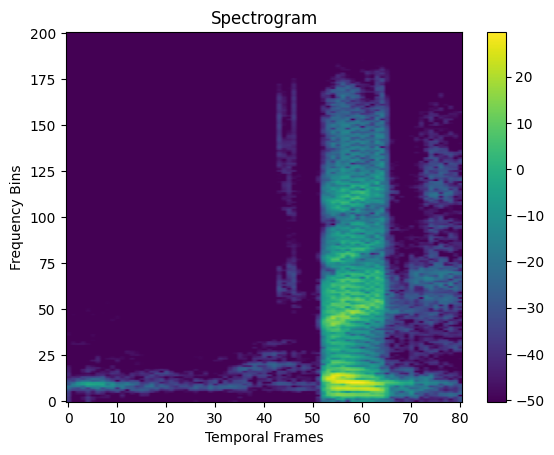

In [ ]:
def extract_spectrogram(wav, n_fft, win_length, hop_length):
  #spectogram extraction using torchaudio
  spectrogram_extractor = torchaudio.transforms.Spectrogram(n_fft, win_length, hop_length) #: < - implement the correct argument calls here!
  spectrogram = spectrogram_extractor(wav)
  return spectrogram

#Utility function to visualize spectrograms.
def plot_spectrogram(spec, title=None, ylabel='Frequency Bins', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('Temporal Frames')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

# Arguments required for spectrogram computation. 
N_FFT = 400  # Number of Fast Fourier Transformer (FFT) points. Controls frequency resolution. Higher value gives more detail in frequency, but lower time resolution. Original: 400
WIN_LENGTH = 400  # Window size in samples. Determines the length of each segment analyzed by the FFT. Original 400
HOP_LENGTH = 200  # Step size between windows in samples. Controls overlap between segments. Smaller values increase overlap, capturing smoother transitions. Original: 200

spectrogram = extract_spectrogram(waveform, n_fft=N_FFT, win_length=WIN_LENGTH, hop_length=HOP_LENGTH)

assert len(spectrogram.shape) == 3

print(f"Spectrogram shape is {spectrogram.shape}")
print(f"Dimension 0 is {spectrogram.shape[0]}, which means there is one spectrogram in this tensor batch.")
print(f"Dimension 1 is {spectrogram.shape[1]}, which means that there are {spectrogram.shape[1]} frequency bins.")
print(f"Dimension 2 is {spectrogram.shape[2]}, which means that there are {spectrogram.shape[2]} temporal frames.")

plot_spectrogram(spectrogram[0, :, :], title="Spectrogram")

Apply mel scale to convert the spectrogram into a mel-spectrogram. This step uses `torchaudio.transforms.MelScale`, which transforms the frequency axis to the mel scale whichbetter matches how humans perceive pitch. This reduces dimensionality and emphasizes perceptually important frequencies.  
See the documentation [here](https://pytorch.org/audio/main/_modules/torchaudio/transforms/_transforms.html#MelScale).

Mel-Spectrogram shape is torch.Size([1, 40, 81])
Dimension 0 is 1, which means there is one mel-spectrogram in this tensor batch.
Dimension 1 is 40, which means that there are 40 mel frequency bins.
Dimension 2 is 81, which means that there are 81 temporal frames.


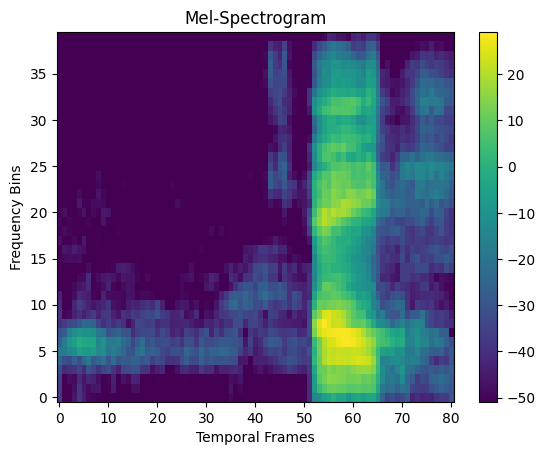

In [ ]:
def extract_mel_spectrogram(wav, n_mels, n_fft, window_length, hop_length):
    #Implement mel scale transform here.
    to_mel_scale = torchaudio.transforms.MelScale(n_mels=n_mels) #: < - implement the correct argument calls here!
    spectrogram = extract_spectrogram(wav, n_fft, window_length, hop_length)
    mel_spectrogram = to_mel_scale(spectrogram)
    return mel_spectrogram

#Arguments required for mel-spectrogram computation
N_MELS = 40 # Number of Mel bands. Controls the number of frequency bins in the mel-spectrogram. A higher number gives more frequency detail.
mel_spectrogram = extract_mel_spectrogram(waveform, n_mels=N_MELS, n_fft=N_FFT, window_length=WIN_LENGTH, hop_length=HOP_LENGTH)

assert len(mel_spectrogram.shape) == 3

print(f"Mel-Spectrogram shape is {mel_spectrogram.shape}")
print(f"Dimension 0 is {mel_spectrogram.shape[0]}, which means there is one mel-spectrogram in this tensor batch.")
print(f"Dimension 1 is {mel_spectrogram.shape[1]}, which means that there are {mel_spectrogram.shape[1]} mel frequency bins.")
print(f"Dimension 2 is {mel_spectrogram.shape[2]}, which means that there are {mel_spectrogram.shape[2]} temporal frames.")

plot_spectrogram(mel_spectrogram[0, :, :], title="Mel-Spectrogram")

Explore the MFCC (Mel Frequency Cepstral Coefficients). For this, I use the `torchaudio.transforms.MFCC` function, which computes a compact representation of the audio signal based on the mel-spectrogram. MFCCs are widely used in speech recognition because they efficiently capture the timbral aspects of speech, making them suitable for machine learning models.  
See the documentation [here](https://pytorch.org/audio/main/generated/torchaudio.transforms.MFCC.html#torchaudio.transforms.MFCC).

MFCCshape is torch.Size([1, 13, 81])
Dimension 0 is 1, which means there is one MFCC in this tensor batch.
Dimension 1 is 13, which means that there are 13 MFCC bins.
Dimension 2 is 81, which means that there are 81 temporal frames.


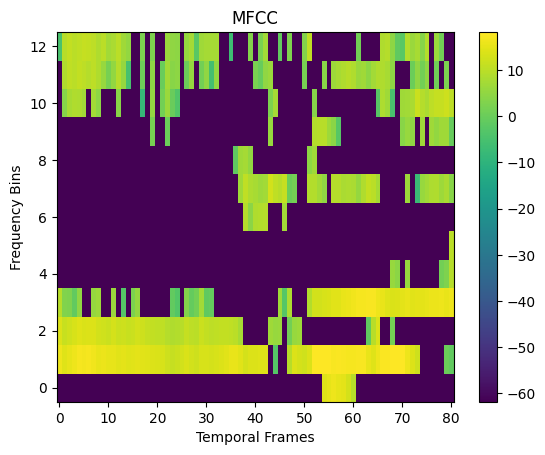

In [ ]:
def extract_mfcc(wav, n_mfcc, mel_kwargs):
    #Implement MFCC extractor here.
    mfcc_extractor = torchaudio.transforms.MFCC(n_mfcc=n_mfcc, melkwargs = mel_kwargs)
    mfcc = mfcc_extractor(wav)
    return mfcc

N_MFCC = 13
MEL_KWARGS = {"n_mels": N_MELS, "n_fft": N_FFT, "win_length": WIN_LENGTH, "hop_length": HOP_LENGTH}
mfcc = extract_mfcc(waveform, n_mfcc=N_MFCC, mel_kwargs=MEL_KWARGS)

assert len(mfcc.shape) == 3

print(f"MFCCshape is {mfcc.shape}")
print(f"Dimension 0 is {mfcc.shape[0]}, which means there is one MFCC in this tensor batch.")
print(f"Dimension 1 is {mfcc.shape[1]}, which means that there are {mfcc.shape[1]} MFCC bins.")
print(f"Dimension 2 is {mfcc.shape[2]}, which means that there are {mfcc.shape[2]} temporal frames.")

plot_spectrogram(mfcc[0, :, :], title="MFCC")

## Summary

To better understand the efficiency of each audio representation, I compared how many values (samples) are needed to characterize the same one-second input audio. The raw waveform contains the most data, while each subsequent feature extraction step compresses the information further:

- **Raw waveform:** Contains all the original samples (e.g., 16,000 for 1 second at 16 kHz).
- **Spectrogram:** Represents the signal in both time and frequency, reducing the number of values compared to the raw waveform.
- **Mel-Spectrogram:** Further compresses the spectrogram by mapping frequencies to the mel scale, focusing on perceptually important information.
- **MFCC:** Provides a very compact representation, using only a small number of coefficients per frame.

This comparison highlights the trade-off between information content and computational efficiency for different audio features.

In [ ]:
print(f"Raw audio waveform shape = {waveform.shape} | Channels = {waveform.shape[0]} | Temporal frames = {waveform.shape[1]} | Total samples = {waveform.shape[0] * waveform.shape[1]}")
print(f"Spectrogram shape = {spectrogram.shape} | Channels = {spectrogram.shape[1]} | Temporal frames = {spectrogram.shape[2]} | Total samples = {spectrogram.shape[1] * spectrogram.shape[2]}")
print(f"Mel-Spectrogram shape = {mel_spectrogram.shape} | Channels = {mel_spectrogram.shape[1]} | Temporal frames = {mel_spectrogram.shape[2]} | Total samples = {mel_spectrogram.shape[1] * mel_spectrogram.shape[2]}")
print(f"MFCC shape = {mfcc.shape} | Channels = {mfcc.shape[1]} | Temporal frames = {mfcc.shape[2]} | Total samples = {mfcc.shape[1] * mfcc.shape[2]}")

Raw audio waveform shape = torch.Size([1, 16000]) | Channels = 1 | Temporal frames = 16000 | Total samples = 16000
Spectrogram shape = torch.Size([1, 201, 81]) | Channels = 201 | Temporal frames = 81 | Total samples = 16281
Mel-Spectrogram shape = torch.Size([1, 40, 81]) | Channels = 40 | Temporal frames = 81 | Total samples = 3240
MFCC shape = torch.Size([1, 13, 81]) | Channels = 13 | Temporal frames = 81 | Total samples = 1053
